In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report




In [45]:
dataset = pd.read_csv('dataset/Dataset_T-ITS.csv')

C:\Users\akira\AppData\Local\Temp\ipykernel_20128\255730488.py:1: DtypeWarning: Columns (35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('dataset/Dataset_T-ITS.csv')


In [46]:
benign = dataset.iloc[2:9424]
raplay_attack = dataset.iloc[26369:38363]
dos_attack = dataset.iloc[13720:25386]
#evil_twin = dataset.iloc[39348:45025]
#fdi = dataset.iloc[50508:53972]

df_DoS_normal = pd.concat([benign, raplay_attack , dos_attack]) #evil_twin, fdi ])

In [47]:
display(df_DoS_normal)

,timestamp_c,frame.number,frame.len,frame.protocols,wlan.duration,wlan.ra,wlan.ta,wlan.da,wlan.sa,wlan.bssid,...,tcp.options,udp.srcport,udp.dstport,udp.length,data.data,data.len,wlan.fc.type,wlan.fc.subtype,time_since_last_packet,class
2,28107.09931,75,104,0,0,4,1,4,1,0,...,0,0,0,0,0,0,0,8,1.123815,benign
3,28114.7857,122,86,2,44,1,0,1,0,0,...,1,0,0,0,0,0,2,8,7.686387,benign
4,28114.88188,124,26,0,60,1,0,1,0,0,...,0,0,0,0,0,0,2,12,0.096183,benign
5,28114.98812,128,26,0,60,1,0,1,0,0,...,0,0,0,0,0,0,2,12,0.106243,benign
6,28115.002,130,86,2,44,1,0,1,0,0,...,1,0,0,0,0,0,2,8,0.013873,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25381,27406.47171,3778,26,0,314,1,0,1,0,0,...,0,0,0,0,0,0,0,12,0.002233,DoS attack
25382,27406.47505,3779,26,0,314,0,1,0,1,0,...,0,0,0,0,0,0,0,12,0.003348,DoS attack
25383,27406.47721,3780,26,0,314,1,0,1,0,0,...,0,0,0,0,0,0,0,12,0.002159,DoS attack
25384,27406.48068,3781,26,0,314,0,1,0,1,0,...,0,0,0,0,0,0,0,12,0.00347,DoS attack


In [48]:
# Primeiro, dividir os dados em treino (60%) e teste+validação (40%)
#train_df, temp_df = train_test_split(df_DoS_normal, test_size=0.4, random_state=42)

# Agora, dividir a parte de teste+validação em teste (20%) e validação (20%)
#test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Exibir o tamanho de cada conjunto para verificar
#print(f"Tamanho do conjunto de treino: {train_df.shape}")
#print(f"Tamanho do conjunto de teste: {test_df.shape}")
#print(f"Tamanho do conjunto de validação: {val_df.shape}")

In [49]:
# split data into X and y
X = df_DoS_normal.iloc[:, 0:37]  # Seleciona todas as linhas e as colunas de 0 a 37
Y = df_DoS_normal.iloc[:, 37]    # Seleciona todas as linhas da coluna 38



In [50]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Obtenha as classes originais
classes_originais = label_encoder.classes_

# Obtenha os números associados às classes originais
numeros_classes = label_encoder.transform(classes_originais)

print("Classes originais:", classes_originais)
print("Números associados às classes originais:", numeros_classes)

Classes originais: ['DoS attack' 'Replay' 'benign']
Números associados às classes originais: [0 1 2]


In [51]:
# Identifica as colunas não numéricas em X
non_numeric_columns = X.select_dtypes(exclude=['int', 'float', 'bool']).columns
print("Colunas não numéricas:", non_numeric_columns)

# Função para tentar converter colunas para numéricas, se falhar usa LabelEncoder
def convert_column(column):
    try:
        # Tenta converter para tipo numérico
        return pd.to_numeric(column)
    except ValueError:
        # Se falhar, usa LabelEncoder para converter
        return LabelEncoder().fit_transform(column)

# Aplica a função de conversão nas colunas não numéricas
for col in non_numeric_columns:
    X[col] = convert_column(X[col])

# Verifica novamente os tipos de dados para garantir que todos são numéricos
print(X.dtypes)


Colunas não numéricas: Index(['timestamp_c', 'frame.number', 'frame.len', 'frame.protocols',
       'wlan.duration', 'wlan.ra', 'wlan.ta', 'wlan.da', 'wlan.sa',
       'wlan.bssid', 'wlan.frag', 'wlan.seq', 'llc.type', 'ip.hdr_len',
       'ip.len', 'ip.id', 'ip.flags', 'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq_raw', 'tcp.ack_raw',
       'tcp.hdr_len', 'tcp.flags', 'tcp.window_size', 'tcp.options',
       'udp.srcport', 'udp.dstport', 'udp.length', 'data.data', 'data.len',
       'wlan.fc.type', 'wlan.fc.subtype', 'time_since_last_packet'],
      dtype='object')


C:\Users\akira\AppData\Local\Temp\ipykernel_20128\1568309991.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = convert_column(X[col])


timestamp_c               float64
frame.number                int64
frame.len                   int64
frame.protocols             int64
wlan.duration               int64
wlan.ra                     int64
wlan.ta                     int64
wlan.da                     int64
wlan.sa                     int64
wlan.bssid                  int64
wlan.frag                   int64
wlan.seq                    int64
llc.type                    int64
ip.hdr_len                  int64
ip.len                      int64
ip.id                       int64
ip.flags                    int64
ip.ttl                      int64
ip.proto                    int64
ip.src                      int64
ip.dst                      int64
tcp.srcport                 int64
tcp.dstport                 int64
tcp.seq_raw                 int64
tcp.ack_raw                 int64
tcp.hdr_len                 int64
tcp.flags                   int64
tcp.window_size             int64
tcp.options                 int64
udp.srcport   

In [52]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded , test_size=test_size, random_state=seed)

In [53]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [54]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [55]:
print(y_pred)
print(predictions)


[0 0 0 ... 2 2 2]
[0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 0, 1, 2, 1, 1, 2, 0, 2, 2, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 

In [56]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.39%


Matriz de confusão não normalizada


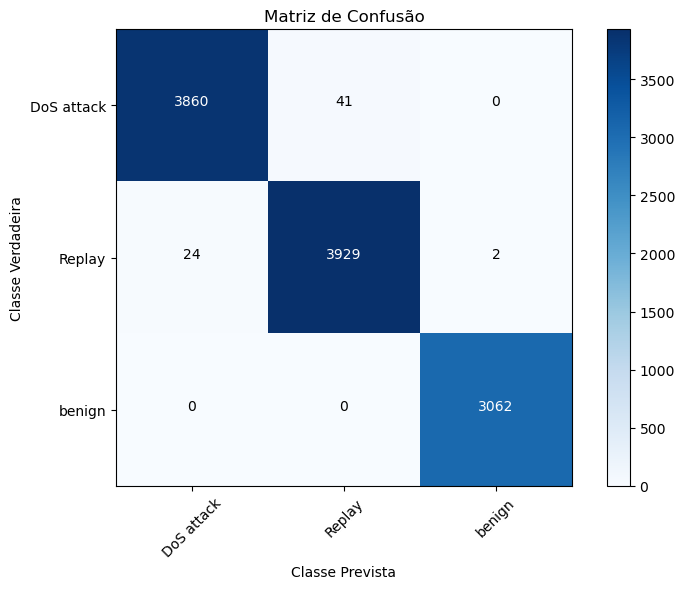

In [57]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão', cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão não normalizada')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Prevista')
    plt.tight_layout()

# Aqui, substitua y_test pelas suas classes verdadeiras e predictions pelas suas previsões
# Confira se você já definiu y_test e predictions antes de executar esta parte
conf_matrix = confusion_matrix(y_test, predictions)

# Definir as classes
classes = ['DoS attack' ,'Replay' ,'benign']#, 'Evil Twin', 'FDI' ]

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes)
plt.show()


In [58]:

# Calcular métricas para um problema multiclasse
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)

# Exibir os resultados
print(f"Precisão: {precision:.2f}")
print(f"Sensibilidade: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nReporte de Classificação:\n", report)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].